# Zajęcia 5 - analiza skupień (klasteryzacja)

## Metoda K-średnich (K-means, algorytm centroidów)

Metoda ta zakłada, że każdy klaster reprezentowany będzie przez jeden centroid. W wyniku działania algoytmu otrzymamy k klastrów reprezentujących wyodrębnione skupiska danych.

Celem algorytmu jest przypisanie do zbioru wektorów kodowych $r_i$, gdzie $ i \in [1, K] $ $M$ $n-$wymiarowych wektorów danych przy jak najmniejszym średnim błędzie kwantyzacji wyrażanym jako:

$$ D = \frac{1}{N} \sum_{i=1}^N d(x_i, r),$$

gdzie $K$ jest liczną elemetów $x_i$ przypisanych do wektora kodowego $r$, a $d$ jest miarą błędu kwantyzacji. Błąd kwantyzacji wyraża się zazwyczaj jako błąd kwadratowy $d(x,r) = \sum_{j=1}^n (x_j-r_j)^2$.

Algorytm jest bardzo prosty:

1. ustalenie liczby centroidów $K$ i maksymalnego błędu kwantyzacji $\varepsilon $, który może zostać popełniony dla problemu klasteryzacji
2. Powtarzanie poniżej iteracji do momentu, aż błąd kwantyzacji będzie mniejszy od założonego lub przekroczona zostanie ustalona z góry liczba kroków iteracyjnych:
    i. podziel $M$ wektorów danych na $K$ grup; wektor $x_j$ przypisywany jest do $i-tej$ grupy jeśli zachodzi nierówność $d(x_j, r_j) \le d(x_j, x_k)$ dla $r_k \neq r_i$
    ii. wyznacz średni błąd kwantyzacji 
    iii. wyznacz centroidy dla wszytskich $i$ grup wektorów i przypisz je do wektorów kodowych
    iv. jeśli $ \frac{D_{m-1} - D_m}{D_m} \lt \varepsilon $ lub liczba kroków została przekroczona - zakończ, w przeciwnym razie - powtórz wszystkie kroki z punktu 2.
 
Oczywiście problem stanowi tutaj dobór odpowiedniej liczby centroidów. Zwykle pomaga spojrzenie na dane i odgórne ustalenie ich liczby. Przy odrobinie szczęścia może okazać się, że nawet za duża liczba centroidów da dobry wynik klasteryzacji i będzie można spróbować powtórzyć procedurę z mniejszą ich liczbą - oczywiście konieczny będzie tutaj osąd wyników po obliczeniach i czytelna ich prezentacja.

Jeszcze jednym problemem jest wybór początkowych wartości wektorów kodowych. Ich zły wybór może doprowadzić do niepoprawnej klasteryzacji (brak zbieżności) lub przekroczenie z góry określonej liczby iteracji.

Oczywiście istnieją metody określania liczby wektorów kodowych i ich początkowych wartości, ale na tym etapie nie będziemy wchodzili w szczegóły - skorzystamy oczywiście z gotowej implementacji algorytmu K-średnich z biblioteki sklearn.

Zbudujmy sobie syntetyczny zbiór danych i przeprowadźmy na nim analizę. Tym razem - stworzymy zbiór, w którym znajdować się będą oceny filmów, dokonane przez kilku kinomanów.

In [6]:
import pandas as pd

ratings = [['Jan',5,5,2,1],['Maria',4,5,3,2],['Robert',4,4,4,3],['Ela',2,2,4,5],['Stanisław',1,2,3,4],['Adam',2,1,5,5]]
titles = ['kinoman','Szczęki','Star Wars','Egzorcysta','Omen']
movies = pd.DataFrame(ratings,columns=titles)
movies

,kinoman,Szczęki,Star Wars,Egzorcysta,Omen
0,Jan,5,5,2,1
1,Maria,4,5,3,2
2,Robert,4,4,4,3
3,Ela,2,2,4,5
4,Stanisław,1,2,3,4
5,Adam,2,1,5,5


Zobaczmy teraz, czy uda nam się pogrupować kinomanów pod względem ich preferencji związanych z filmami. Dane skonstruowane zostały tak, że mamy dwa filmy będące horrorami, jeden film science fiction i jeden film, który sklasyfikować można jako dreszczowiec. Oczywiste więc byłoby grupowanie kinomanów przynajmniej na 2 lub 3 grupy. Spróbujemy sklasteryzować ich na od 1 do 6 grup.

### K-średnich - 2 klastry

In [8]:
from sklearn import cluster

data = movies.drop('kinoman',axis=1)
k_means = cluster.KMeans(n_clusters=2, max_iter=50, random_state=1)
k_means.fit(data) 
labels = k_means.labels_
pd.DataFrame(labels, index=movies.kinoman, columns=['Cluster ID'])

,Cluster ID
kinoman,
Jan,0
Maria,0
Robert,0
Ela,1
Stanisław,1
Adam,1


In [9]:
centroids = k_means.cluster_centers_
pd.DataFrame(centroids,columns=data.columns)

,Szczęki,Star Wars,Egzorcysta,Omen
0,4.333333,4.666667,3.0,2.000000
1,1.666667,1.666667,4.0,4.666667


Z danych widać, że klaster $0$ ma wyższe wartości ocen dla filmów: Szczęki i Star Wars, $1$ dla horrorów. Może wyciągnąć z tego jakiś wniosek? Powiedzmy, że w przypadku $0$ kinomani wolą filmy akcji (chociaż to akurat kiepskie określenie, ale jest to chyba jedyny wspólny mianownik dla tych filmów), a w przypadku $1$ - kinomani wysoko oceniają horrory, a bardzo nisko filmy akcji.

Skorzystajmy teraz z nauczonych centroidów do zgrupowania preferencji innych użytkowników, na których centroidy nie były wyznaczane. Potraktujemy więc pierwszą grupę jako zbiór treningowy, a drugą grupę, jako zbiór testowy.

In [10]:
import numpy as np

testData = np.array([[4,5,1,2],[3,2,4,4],[2,3,4,1],[3,2,3,3],[5,4,1,4]])
labels = k_means.predict(testData)
labels = labels.reshape(-1,1)
usernames = np.array(['Paulina','Kamil','Luiza','Tomasz','Janusz']).reshape(-1,1)
cols = movies.columns.tolist()
cols.append('Cluster ID')
newusers = pd.DataFrame(np.concatenate((usernames, testData, labels), axis=1),columns=cols)
newusers

,kinoman,Szczęki,Star Wars,Egzorcysta,Omen,Cluster ID
0,Paulina,4,5,1,2,0
1,Kamil,3,2,4,4,1
2,Luiza,2,3,4,1,0
3,Tomasz,3,2,3,3,1
4,Janusz,5,4,1,4,0


Jak widać - efekty są zbliżone, tak więc klasteryzacja przebiegła poprawnie.

Zastanówmy się nad problemem liczby klastrów - może okaże się, że o wiele lepsze wyniki dostaniemy, gdy założymy więcej grup. W tym celu przeprowadzimy klasteryzację na różnej liczbie grup i porównamy sumę błędów kwadratowych (SSE). Oczywiście - zależy nam na minimalizacji SSE, ale nie możemy też przesadzić z ich liczbą.

Text(0, 0.5, 'SSE')

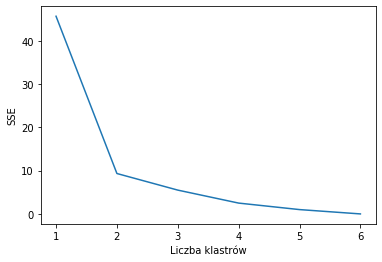

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(data)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Liczba klastrów')
plt.ylabel('SSE')

## Hierarchiczna analiza klastrów (HCA)

Hierarchiczna analiza klastrów jest metodą, która dzieli obserwacje na grupy, bazując na podobieństwie pomiędzy obserwacjami. Nie jest tutaj konieczne określenie z góry liczby klastrów. Wśród metod wyróżna się ich typy:

1. metody aglomeracyjne, w których każda obserwacja tworzy na początku jeden klaster a następnie pary klastrów są ze sobą scalane (dwa najbardziej zbliżone do sobie klastry); idea zakłada, że zaczynamy od pojedynczych klastrów i pniemy się iteracyjnie w górę hierarchii
2. metody deglomeracyjne, w których na początku wszystkie obserwacje znajdują się w jednym klastrze, a następnie najbardziej podobne do siebie obserwacje dzielone są na mniejsze klasy; operacja działa rekurencyjnie, poruszając się w dół hierarchii

Prezentacją danych w metodach hierarchicznych są dendrogramy, będące wielopoziomowymi hierarchiami, w któych klastry z jednego poziomu są ze sobą łączone i tworzą większe klastry na kolejnych poziomach.

Do określania odległości pomiędzy obserwacjami stosuje się następujące miary odległości (metryki):

1. euklidesową, gdzie: $d_E = \sqrt{\sum_i (a_i-b_i)^2}$
2. kwadrtatową euklidesową, gdzie: $d_E^2 = \sum_i (a_i-b_i)^2 $
3. Manhattan, gdzie: $d_M = \sum_i |a_i - b_i|$
4. maksymalną odległość, gdzie $d_{\inf} = max_i |a_i - b_i|$

To, w jaki sposób definiowana jest odległość pomiędzy dwoma punktami określa metoda połączenia. Metody połączenia wybiera się zazwyczaj emipirycznie, testując, która działa najlepiej na posiadanych danych. Najczęściej spotykanie metody połączenia to:

1. pojedyncze połączenie, gdzie odległość pomiędzy dwoma klastrami jest minimalną odległością między obserwacją w jednym klastrze, a obserwacją w drugim klastrze  (działa dobrze, gdy klastry są widocznie oddzielone)
2. kompletne połączenie, gdzie odległość pomiędzy dwoma klastrami jest maksymalną odległością między obserwacją w jednym klastrze, a obserwacją w drugim klastrze (działa źle tam, gdzie są punkty odstające)
3. średnie połączenie, gdzie odległość pomiędzy dwoma klastrami jest średnią odległością pomiędzy obserwacją w jednym klastrze a obserwacją w innym klastrze
4. połączenie centroidowe, gdzie odległość pomiędzy dwoma klastrami jest odległością pomiędzy centroidami klastrów
5. połączenie medianowe, gdzie odległość pomiędzy dwoma klastrami jest medianą odległości pomiędzy obserwacją w jednym klastrze a obserwacją w innym klastrze (działa dobrze tam, gdzie występują punkty odstające)
6. połącznie Ward'a, gdzie odległość pomiędzy dwoma klastrami jest sumą kwadratów odchyleń od punktów do centroidów (działa dobrze tam, gdzie łatwo zminimalizować sumę kwadratów odległości wewnątrz klastra)
7. połączenie McQuitty'ego, gdzie połączenie klastrów zachodzi, gdy ich odległości od nowego klastra są średnią arytmetyczną odległości jednego i drugiego klastra od klastra wynikowego (uniezależnia się wtedy odległości od kombinacji klastrów a nie od indywidualnych obserwacji w klastrach)

Spójrzmy więc na przykłady takiej analizy. Skorzystamy z gotowej implementacji z biblioteki scipy. Skupumy się na trzech pierwszych metodach połączenia (pojedyncze - MIN, kompletne - MAX i średnie - AVG)

Dane, które wykorzystamy to zbiór kręgowców, który posłużył nam przy omawianiu metod klasyfiakcji.

In [12]:
import pandas as pd

data = pd.read_csv('./Dane/vertebrate.csv',header='infer')
data

,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,human,1,1,0,0,1,0,mammals
1,python,0,0,0,0,0,1,reptiles
2,salmon,0,0,1,0,0,0,fishes
3,whale,1,1,1,0,0,0,mammals
4,frog,0,0,1,0,1,1,amphibians
5,komodo,0,0,0,0,1,0,reptiles
6,bat,1,1,0,1,1,1,mammals
7,pigeon,1,0,0,1,1,0,birds
8,cat,1,1,0,0,1,0,mammals
9,leopard shark,0,1,1,0,0,0,fishes


### MIN

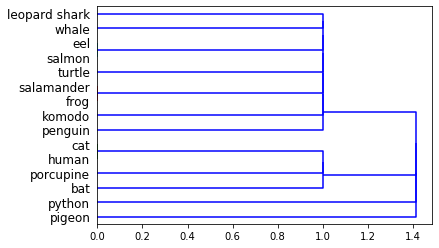

In [16]:
import numpy
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
%matplotlib inline

names = data['Name']
Y = data['Class']
X = data.drop(['Name','Class'],axis=1)
Z = hierarchy.linkage(X.to_numpy(), 'single')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

### MAX

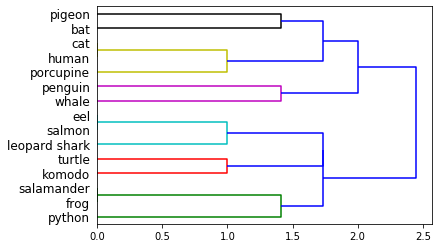

In [17]:
Z = hierarchy.linkage(X.to_numpy(), 'complete')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

### AVG

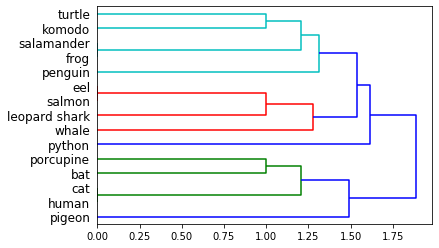

In [19]:
Z = hierarchy.linkage(X.to_numpy(), 'average')
dn = hierarchy.dendrogram(Z,labels=names.tolist(),orientation='right')

Warto teraz porównać wyniki klasteryzacji z klasyfikacją. Widać podobieństwo, prawda? Chociaż wynikiem nie jest tutaj określenie ssak/nie-ssak, a zgrupowanie ze sobą najbardziej podobnych kręgowców.

## Metody bazujące na analizie gęstości

Ta grupa metod wywodzi się z metod ucznia nienadzorowanego. Identyfikują one klastry w zbiorze danych bazując na założeniu, że dane w przestrzeni tworzą obszary o dużej gęstości punktów, a klastry separowane między sobą obszarami o niskiej gęstości punktów. Dane w obszarach o niskiej gęstości punktów są zazwyczaj traktowane jako punkty odstające.

Najpopularniejszym algorytmem bazującym na analizie gęstości jest algorytm DBScan (ang. Densiti-Based Spatial clusterinf of applications with noise). Zasada jego działania jest następująca:

1. znajdź punkty w sąsiedztwie $\varepsilon$ od każdego z punktu i zidentyfikuj obszary, w których mieści się więcej punktów, niż ich założona minimalna liczba.
2. znajdź spójną składową grafu zidentyfikowanych obszarów, ignorując przy tym punkty spoza obszaru
3. przypisz punkty, które zostały zignorowane do najbliższego obszaru jeśli znajdują się one w najbliższym otoczeniu (odległość mniejsza niż $\varepsilon$, a w przeciwnym razie potraktuj je jako szum

Obszar jest w tym przypadku określany poprzez główny punkt, wokół którego układają się inne wartości danych.

Zobaczmy jak działa taka klasteryzacja na dość skomplikowanym zbiorze dancyh.

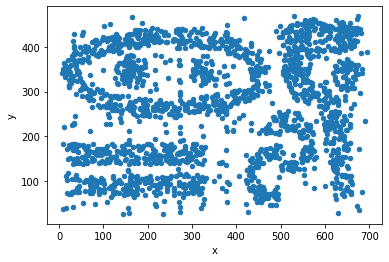

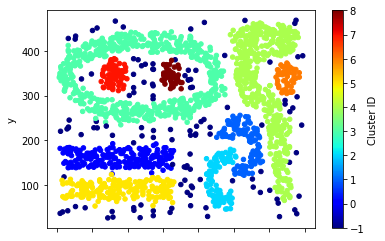

In [22]:
import pandas as pd

data = pd.read_csv('./Dane/chameleon.data', delimiter=' ', names=['x','y'])
data.plot.scatter(x='x',y='y')

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=15.5, min_samples=5).fit(data)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = pd.DataFrame(db.labels_,columns=['Cluster ID'])
result = pd.concat((data,labels), axis=1)
result.plot.scatter(x='x',y='y',c='Cluster ID', colormap='jet')

## Grupowanie widmowe (spectral clustering)

Jest to metoda wykorzystująca wartości własne macierzy podobieństwa, aby zredukować liczbę wymiarów danych przed klasteryzacją. Metoda ta wykorzystywana jest do analizy obrazów. Ideowo jest zbliżona do metody K-średnich,  ale ma zdjęte więzy związane z macierzą współczynników normalizujących. Widać również podobieństwo do metody DBScan, która jest tak na prawdę szczególnym przypadkiem grupowania widmowego (używa asymetrycznych macierzy sąsiedztwa grafu z usuniętymi krawędziami dla punktów w obszarach o małej gęstości danych).

Macierz sąsiedztwa budowana jest tutaj jako macierz $N x N$ dla zbioru zawierającego $N$ obserwacji. Jej elementy to nic innego jak odległości pomiędzy punktami (mogą być wyrażone w dowolnej metryce).

Widmo macierzy jest zbiorem jej wartości własnych, tak więc mając operator $T: V \rightarrow V$ nad skończenie wymiarową przestrzestrzenią wektorową, widmo to zbór wartości skalarnych $\lambda$, dla którcych równanie $T - \lambda I$ nie jest odwracalne.

Zobaczmy jak radzi sobie grupowanie widmowe na zbiorach, które od razu, na pierwszy rzut oka, nie dadzą się poprawnie sklasteryzować z wykorzystaniem wcześniejszych metod, ze względu na charakterystyczne skupienia punktów.

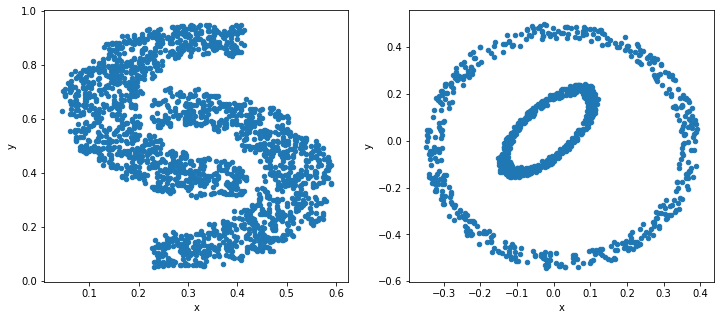

In [23]:
import pandas as pd

data1 = pd.read_csv('./Dane/2d_data.txt', delimiter=' ', names=['x','y'])
data2 = pd.read_csv('./Dane/elliptical.txt', delimiter=' ', names=['x','y'])

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
data1.plot.scatter(x='x',y='y',ax=ax1)
data2.plot.scatter(x='x',y='y',ax=ax2)

Najpierw próba klasteryzacji z wykorzystaniem algorytmu K-średnich:


Text(0.5, 1.0, 'K-Średnich')

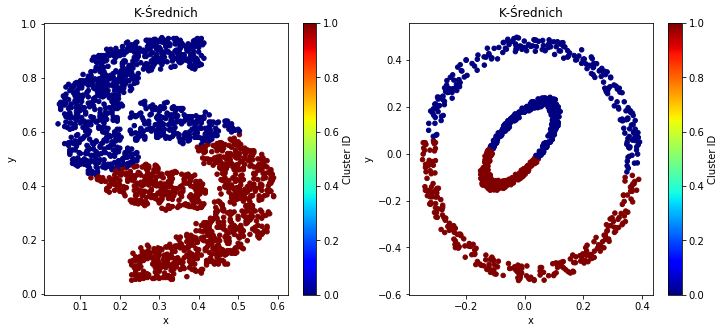

In [24]:
from sklearn import cluster

k_means = cluster.KMeans(n_clusters=2, max_iter=50, random_state=1)
k_means.fit(data1)
labels1 = pd.DataFrame(k_means.labels_,columns=['Cluster ID'])
result1 = pd.concat((data1,labels1), axis=1)

k_means2 = cluster.KMeans(n_clusters=2, max_iter=50, random_state=1)
k_means2.fit(data2)
labels2 = pd.DataFrame(k_means2.labels_,columns=['Cluster ID'])
result2 = pd.concat((data2,labels2), axis=1)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
result1.plot.scatter(x='x',y='y',c='Cluster ID',colormap='jet',ax=ax1)
ax1.set_title('K-Średnich')
result2.plot.scatter(x='x',y='y',c='Cluster ID',colormap='jet',ax=ax2)
ax2.set_title('K-Średnich')

Na wykresach definitywnie widać dwa klastry, jednak metoda K-średnich, ze względu na swoją secyfikę, nie poradziła sobie w tym przypadku. 

Text(0.5, 1.0, 'Grupowanie widmowe')

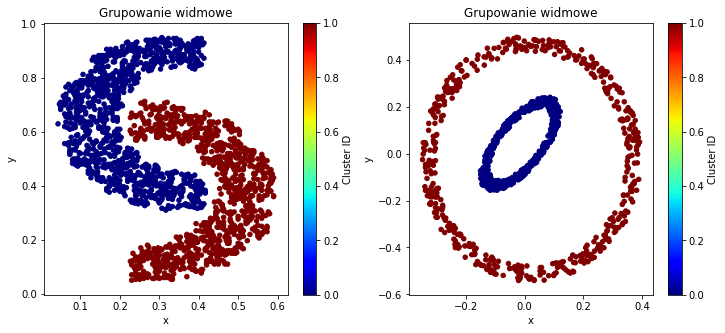

In [28]:
from sklearn import cluster
import pandas as pd

spectral = cluster.SpectralClustering(n_clusters=2,random_state=1,affinity='rbf',gamma=5000)
spectral.fit(data1)
labels1 = pd.DataFrame(spectral.labels_,columns=['Cluster ID'])
result1 = pd.concat((data1,labels1), axis=1)

spectral2 = cluster.SpectralClustering(n_clusters=2,random_state=1,affinity='rbf',gamma=1000)
spectral2.fit(data2)
labels2 = pd.DataFrame(spectral2.labels_,columns=['Cluster ID'])
result2 = pd.concat((data2,labels2), axis=1)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
result1.plot.scatter(x='x',y='y',c='Cluster ID',colormap='jet',ax=ax1)
ax1.set_title('Grupowanie widmowe')
result2.plot.scatter(x='x',y='y',c='Cluster ID',colormap='jet',ax=ax2)
ax2.set_title('Grupowanie widmowe')

Jak widać - poprawność klasyfikacji jest oczywista. Jako miara odległości (podobieństwa) zoatała tutaj zastosowana radialna gaussowska funkcja bazowa, znana już z poprzednich zajęć. Polecam jeszcze posprawdzać jak zachowuje się klasteryzacja w zależności od parametru gamma (kernel parameter) i od wyboru innej metody określania podobieństwa (np. nearest_neighbors, precomputed itp.) - pełna dokumentacja metody znajduje się na stronie https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html.

# Zadanie

Przetestuj poznane metody klasteryzacji na zbiorze IRIS, który już dobrze znasz. Na samym końcu - oceń wyniki i skomentuj krótko, która metoda klasteryzacji i dlaczego przyniosła najlepsze rezultaty. W przypadku dendrogramów - spróbuj otrzymać klasteryzację na podstawie cech, a każdy z rekordów traktuj jako osoby element klasy, których chcesz poddać klasteryzacji. W przypadku innych metod - sprawdź kilka miar odległości i różne wartości parametrów związanych z metodą. Postaraj się znaleźć te najbardziej optymalne.

